<a href="https://colab.research.google.com/github/denisa-cernatoiu/ic1/blob/main/try10_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rishitchs_final_flowers_course_project_dataset_path = kagglehub.dataset_download('rishitchs/final-flowers-course-project-dataset')

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

dataset_path = '/kaggle/input/final-flowers-course-project-dataset/Flowers_Dataset_Revised/Flowers_Dataset_Revised/newFlowers'
labels = []
img_vect = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        flower = cv2.imread(os.path.join(dirname, filename))
        flower = cv2.resize(flower, (150,150))
        flower = cv2.cvtColor(flower, cv2.COLOR_BGR2RGB)
        img_vect.append(flower.flatten())
        labels.append(os.path.basename(dirname))

num_pixels = img_vect[0].shape[0]  # total number of pixels per image
pixel_cols = [f'pixel{i+1}' for i in range(num_pixels)]  # pixel1, pixel2, ...
df = pd.DataFrame(np.array(img_vect), columns=pixel_cols)

labels = np.unique(labels, return_inverse=True)[1]
df['labels'] = np.array(labels)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4135 entries, 0 to 4134
Columns: 67501 entries, pixel1 to labels
dtypes: int64(1), uint8(67500)
memory usage: 266.2 MB


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel67492,pixel67493,pixel67494,pixel67495,pixel67496,pixel67497,pixel67498,pixel67499,pixel67500,labels
0,45,44,39,46,45,40,48,48,42,48,...,72,50,37,73,51,38,73,51,38,1
1,38,30,11,35,28,9,32,26,7,24,...,18,18,6,16,17,5,17,18,5,1
2,159,163,164,162,166,169,157,161,163,161,...,59,77,39,61,79,40,62,80,42,1
3,212,199,0,210,194,0,209,186,1,193,...,38,26,38,38,26,38,37,25,37,1
4,9,12,1,10,13,2,11,14,3,11,...,9,11,0,9,10,2,9,10,2,1


In [ ]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle = True
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (3308, 67500)
y_train shape: (3308,)


In [ ]:
# normalization

X = X.astype(np.float32) / 255.0

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

In [ ]:
# pca+svm pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=200, random_state=42)),
    ('svm', SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        decision_function_shape='ovr',
        random_state=42
    ))
])

In [ ]:
# grid search for C and gamma
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 0.01, 0.1, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'svm__C': 1, 'svm__gamma': 'scale'}
Best CV accuracy: 0.5447367579105173


In [ ]:
# calibrating probabilities for ROC-AUC
calibrated_svm = CalibratedClassifierCV(grid.best_estimator_, cv=5)
calibrated_svm.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=200,
                                                      random_state=42)),
                                                 ('svm',
                                                  SVC(C=1,
                                                      class_weight='balanced',
                                                      probability=True,
                                                      random_state=42))]))

In [ ]:
# evaluation
y_pred = calibrated_svm.predict(X_test)
y_proba = calibrated_svm.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.5042

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       149
           1       0.47      0.51      0.49       205
           2       0.50      0.40      0.44       146
           3       0.55      0.74      0.63       140
           4       0.51      0.41      0.45       187

    accuracy                           0.50       827
   macro avg       0.51      0.51      0.50       827
weighted avg       0.50      0.50      0.50       827

Confusion Matrix:
[[ 75  48   6  12   8]
 [ 33 105   8  44  15]
 [ 15  29  58   7  37]
 [  8  12   4 103  13]
 [ 18  31  40  22  76]]


In [ ]:
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"\nMacro ROC-AUC: {roc_auc:.4f}")


Macro ROC-AUC: 0.8067


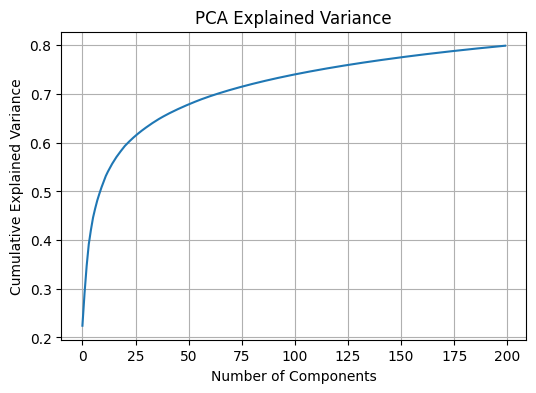

[CV] END .......................svm__C=0.1, svm__gamma=scale; total time= 1.7min
[CV] END .......................svm__C=0.1, svm__gamma=scale; total time= 1.6min
[CV] END ........................svm__C=0.1, svm__gamma=0.01; total time= 1.7min
[CV] END .........................svm__C=0.1, svm__gamma=0.1; total time= 1.6min
[CV] END ...........................svm__C=0.1, svm__gamma=1; total time= 1.6min
[CV] END .........................svm__C=1, svm__gamma=scale; total time= 1.6min
[CV] END .........................svm__C=1, svm__gamma=scale; total time= 1.6min
[CV] END ..........................svm__C=1, svm__gamma=0.01; total time= 1.7min
[CV] END ...........................svm__C=1, svm__gamma=0.1; total time= 1.6min
[CV] END .............................svm__C=1, svm__gamma=1; total time= 1.6min
[CV] END ........................svm__C=10, svm__gamma=scale; total time= 1.6min
[CV] END ........................svm__C=10, svm__gamma=scale; total time= 1.6min
[CV] END ...................

In [ ]:
import matplotlib.pyplot as plt

pca = grid.best_estimator_.named_steps['pca']
explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(explained)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
# 5-Fold CV with best model (sanity check)
cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

[CV] END .......................svm__C=0.1, svm__gamma=scale; total time= 1.7min
[CV] END ........................svm__C=0.1, svm__gamma=0.01; total time= 1.7min
[CV] END ........................svm__C=0.1, svm__gamma=0.01; total time= 1.6min
[CV] END .........................svm__C=0.1, svm__gamma=0.1; total time= 1.6min
[CV] END ...........................svm__C=0.1, svm__gamma=1; total time= 1.6min
[CV] END .........................svm__C=1, svm__gamma=scale; total time= 1.6min
[CV] END ..........................svm__C=1, svm__gamma=0.01; total time= 1.7min
[CV] END ..........................svm__C=1, svm__gamma=0.01; total time= 1.7min
[CV] END ...........................svm__C=1, svm__gamma=0.1; total time= 1.6min
[CV] END .............................svm__C=1, svm__gamma=1; total time= 1.6min
[CV] END ........................svm__C=10, svm__gamma=scale; total time= 1.6min
[CV] END .........................svm__C=10, svm__gamma=0.01; total time= 1.7min
[CV] END ...................

In [ ]:
# Check total variance explained
grid.best_estimator_.named_steps['pca'].explained_variance_ratio_.sum()

0.7992475494249274